In [1]:
import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

#from scipy.integrate import solve_ivp
from scipy.integrate import ode

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
##########################################################################################
### Input Data

OutputDir          = WORKSPACE_PATH + '/ROMNet/Data_1DRA_Clean/'
FigDir             = OutputDir + '/fig/'

tStratch           = 1.
t1                 = 0.1
dt                 = 0.01
Nt                 = 11

Ns                 = 50    # number of scalars
Nx                 = 300   # number of collocation points
Lx                 = 1.0   # domain size 

NVarsRed           = 4

##########################################################################################

try:
    os.makedirs(OutputDir)
except:
    pass
try:
    os.makedirs(FigDir)
except:
    pass
try:
    os.makedirs(OutputDir+'/orig_data/')
except:
    pass

In [3]:
##########################################################################################
### Defining ODE and its Parameters

def DiffReacAdvODE(x, y, dx, xx, ns, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec):
#def DiffReacAdvODE(t, y):
    Nx   = int(len(y)/Ns)
    dydt = np.zeros(y.shape[0])
    
    Y = np.zeros((Ns, Nx))
    for iS in range(Ns):
        Y[iS,:] = y[0+iS*Nx:Nx+iS*Nx]

    dYdt_Diff = np.zeros((Ns,Nx))
    Y_Adv     = np.zeros((Ns,Nx))
    for iX in range(-1,Nx-1):
        DiffM           = DiffFun(xx[iX], Ns)
        dYdt_Diff[:,iX] = np.matmul(DiffM, (Y[:,iX+1] - Y[:,iX-1]) / (2.*dx) )
        AdvecM          = AdvecFun(xx[iX], Ns)
        Y_Adv[:,iX]     = np.matmul(AdvecM, Y[:,iX])
        
    dYdt  = np.zeros((Ns,Nx))
    for iX in range(-1,Nx-1):
        Diff       = (dYdt_Diff[:,iX+1] - dYdt_Diff[:,iX-1]) / (2.*dx)
        Advec      = (    Y_Adv[:,iX+1] -     Y_Adv[:,iX-1]) / (2.*dx)
        
        #ReacM = ReacFun(xx[iX], ns)
        #Reac  = np.matmul(ReacM, Y[:,iX])
        
#         #KInel, KDiss, KRec = ReacFun(xx[iX], ns)
#         Reac       = Diff*0.0
#         Reac[0:-1] = (- KDiss*Y[0:-1,iX] + KRec*Y[-1,iX]**2)*Y[-1,iX] #+ (np.matmul(KInelT, Y[0:-1,iX]))*Y[-1,iX]
#         Reac[-1]   = np.sum( (KDiss*Y[0:-1,iX] - KRec*Y[-1,iX]**2)*Y[-1,iX] )
        
        Reac       = (np.matmul(KInelT, Y[:,iX]))
        
        dYdt[:,iX] = Reac + Diff + Advec # Diff + Advec + Reac
        
    
    dydt = dYdt.flatten()
        
    return dydt

In [4]:
### Create Initial Conditions

dx = Lx/Nx           # grid spacing
X  = np.zeros((Ns,Nx))
x  = np.zeros(Nx*Ns) 
for iS in range(0,Ns):
    x[0+iS*Nx:Nx+iS*Nx] = np.linspace(0., Lx-dx, Nx)
    X[iS,:]             = np.linspace(0., Lx-dx, Nx)
xx = x[0:Nx]

#initial profile
sig = 0.05       
y0  = 1.0/(sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (x-0.5 )/sig )**2.  )
#y0  = np.piecewise(x, [np.abs(x-0.5) < 0.05, np.abs(x-0.5) >= 0.05], [10, 0])


Y0 = np.zeros((Ns,Nx))
for iS in range(Ns):
    Y0[iS,:] = 1.0 / ( sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (X[iS,:]-0.5 )/sig )**2. )
    #Y0[iS,:] = np.piecewise(X[iS,:], [np.abs(X[iS,:]-0.5) < 0.05, np.abs(X[iS,:]-0.5) >= 0.05], [10, 0])

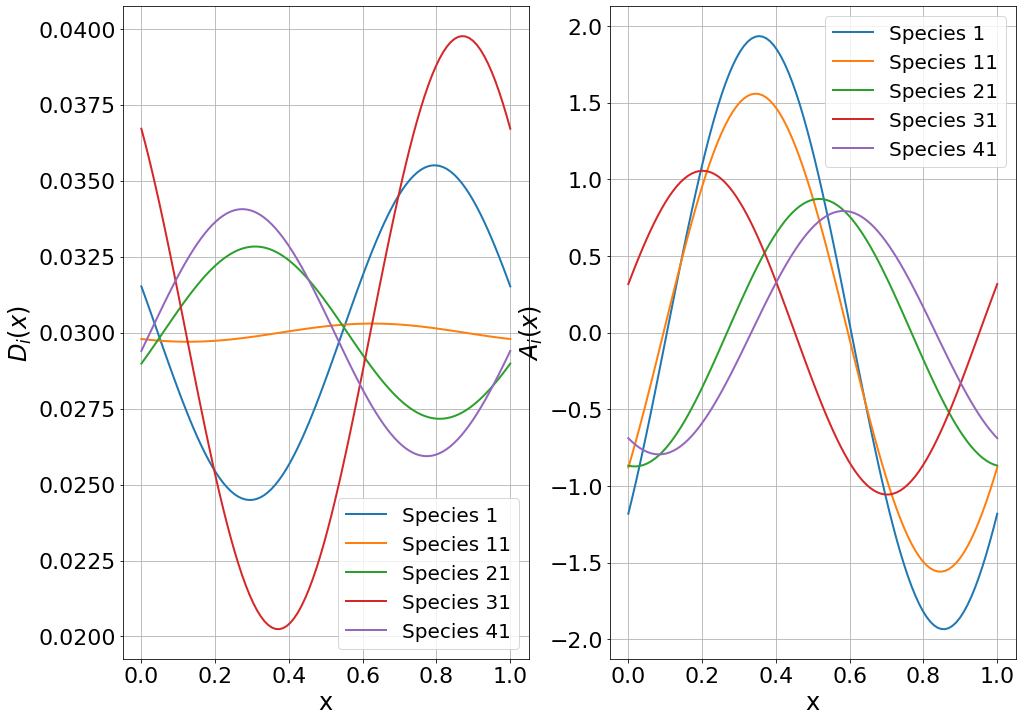

In [5]:
### Create Matrixes of Coefficients

#D     = 0.03*np.ones((Ns,1)) 
#Ad    = 1.0*np.ones((Ns,1))
#alpha = 3.00*np.ones((Ns,1))

# D     = 0.03 + 0.01*np.random.rand(Ns)
# Ad    = 1.0*np.random.rand(Ns) - 0.5
# alpha = 2.0*np.random.rand(Ns) - 1.0

# D     = np.diag(D)
# Ad    = np.diag(Ad)
# alpha = np.diag(alpha)

def DiffFun(x, Ns):
    np.random.seed(3)
    DiffC1 = 0.01*np.random.rand(Ns) 
    DiffC2 = 2.*np.pi*np.random.rand(Ns)
    DiffV  = DiffC1 * np.cos(x*(2.*np.pi)+DiffC2) + 0.03
    #DiffV  = np.zeros(Ns)
    DiffM  = np.diag(DiffV)
    return DiffM

def AdvecFun(x, Ns):
    np.random.seed(4)
    AdvecC1 = 2.0*np.random.rand(Ns)
    AdvecC2 = 2.*np.pi*np.random.rand(Ns)
    AdvecV  = AdvecC1 * np.sin(x*(2.*np.pi) + AdvecC2)
    #AdvecV  = np.zeros(Ns)
    AdvecM  = np.diag(AdvecV)
    return AdvecM

# def ReacFun(x, ns):
#     np.random.seed(5)
#     ReacM  = np.diag(6.0*np.random.rand(Ns) - 3.0)
#     return ReacM
def ReacFun(x, Ns):
#     E     = np.linspace(0.0, 4.0, Ns-1)
#     T     = 1.0
#     KInel = np.zeros((Ns-1,Ns-1))
#     for i in range(Ns-1):
#         for j in range(i):
#             Deltai     = i-j
#             DeltaE     = E[i]-E[j]
#             KInel[i,j] = 1.e3 * np.exp(-DeltaE/T)
#             KInel[j,i] = KInel[i,j] * np.exp(-DeltaE/T)
#     KInel = KInel - np.diag(np.sum(KInel,axis=1))
#     KDiss = np.exp(E/T)
#     KRec  = KDiss / 100
    E     = np.linspace(0.0, 4.0, Ns)
    T     = 1.0
    KInel = np.zeros((Ns,Ns))
    for i in range(Ns):
        for j in range(i):
            Deltai     = i-j
            DeltaE     = E[i]-E[j]
            KInel[i,j] = 1.e1 * np.exp(-DeltaE/T)
            KInel[j,i] = KInel[i,j] * np.exp(-DeltaE/T)
    KInel = KInel - np.diag(np.sum(KInel,axis=1))
    KDiss = 0
    KRec  = 0
    return KInel, KDiss, KRec

KInel, KDiss, KRec = ReacFun(0., Ns)
KInelT = KInel.T



### Plot Coefficients

NTemp      = 100
DiffMPlot  = np.zeros((Ns,NTemp))
AdvecMPlot = np.zeros((Ns,NTemp))
ix         = 0
xTemp      = np.linspace(0.,1.,NTemp)
for ix in range(NTemp):
    DiffMPlot[:,ix]  = np.diag(DiffFun(xTemp[ix], Ns))
    AdvecMPlot[:,ix] = np.diag(AdvecFun(xTemp[ix], Ns))
    ix+=1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
Slice = list(range(0,50,10))

ax1.plot(xTemp, DiffMPlot[Slice].T)
ax1.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax1.set_xlabel('x', fontsize=24)
ax1.set_ylabel(r'$D_i(x)$', fontsize=24)
#ax1.set_xticks(fontsize=20)
#ax1.set_yticks(fontsize=20)
ax1.grid()

ax2.plot(xTemp, AdvecMPlot[Slice].T)
ax2.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax2.set_xlabel('x', fontsize=24)
ax2.set_ylabel(r'$A_i(x)$', fontsize=24)
#ax2.set_xticks(fontsize=20)
#ax2.set_yticks(fontsize=20)
ax2.grid()


plt.show()

In [6]:
# Run integation

xMat  = np.zeros((Ns,Nx))
yMat  = np.zeros((Ns,Nx))
yTemp = np.zeros((Ns,Nx))
for i in range(0,Ns):
    xMat[i,:] =  x[0+i*Nx:Nx+i*Nx]
    yMat[i,:] = y0[0+i*Nx:Nx+i*Nx]
    
    
# tout       = [0.]
# tout       = np.concatenate((np.array(tout), np.linspace(0.01, 0.1, Nt)), axis=0)
# SOLVER     = 'BDF'
# output     = solve_ivp( DiffReacAdvODE, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-10)#, first_step=1.e-14)

# NTott = len(output.t)
# for it in range(NTott):
#     t = output.t[it]
#     u = output.y[:,it]
    
#     for i in range(0,ns):
#         yTemp[i,:] = output.y[0+i*nx:nx+i*nx,it]
#     yMat = np.concatenate((yMat,yTemp), axis=1)
    
    
r          = ode(DiffReacAdvODE).set_integrator('vode', method='bdf', order=5, atol=1e-10)
r.set_initial_value(y0, 0.0).set_f_params(dx, xx, Ns, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec)

tVec = [0.0]  
while r.successful() and r.t < t1:
    print(r.t+dt)
    tVec.append(r.t+dt)
    y_next = r.integrate(r.t+dt)
    for i in range(0,Ns):
        yTemp[i,:] = y_next[0+i*Nx:Nx+i*Nx]
    yMat = np.concatenate((yMat,yTemp), axis=1)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999


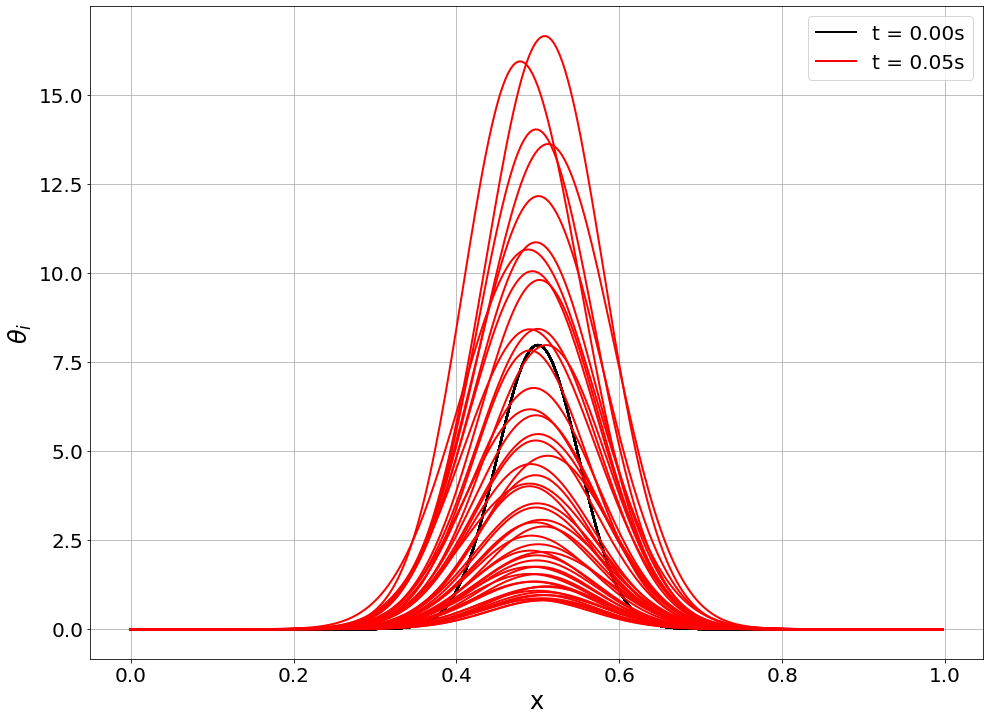

In [7]:
fig = plt.figure(figsize=(16, 12))

it = 0
iS = 0
plt.plot(x[0+iS*Nx:Nx+iS*Nx], yMat[iS,0+it*Nx:Nx+it*Nx],  'k-', label='t = '+'{:.2f}'.format(tVec[it])+'s')  
for iS in range(1,Ns):
    plt.plot(x[0+iS*Nx:Nx+iS*Nx], yMat[iS,0+it*Nx:Nx+it*Nx],  'k-')  

it = 5
plt.plot(x[0+iS*Nx:Nx+iS*Nx],yMat[iS,0+it*Nx:Nx+it*Nx],  'r-', label='t = '+'{:.2f}'.format(tVec[it])+'s') 
for iS in range(1,Ns):
    plt.plot(x[0+iS*Nx:Nx+iS*Nx],yMat[iS,0+it*Nx:Nx+it*Nx],  'r-') 

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\theta_i$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

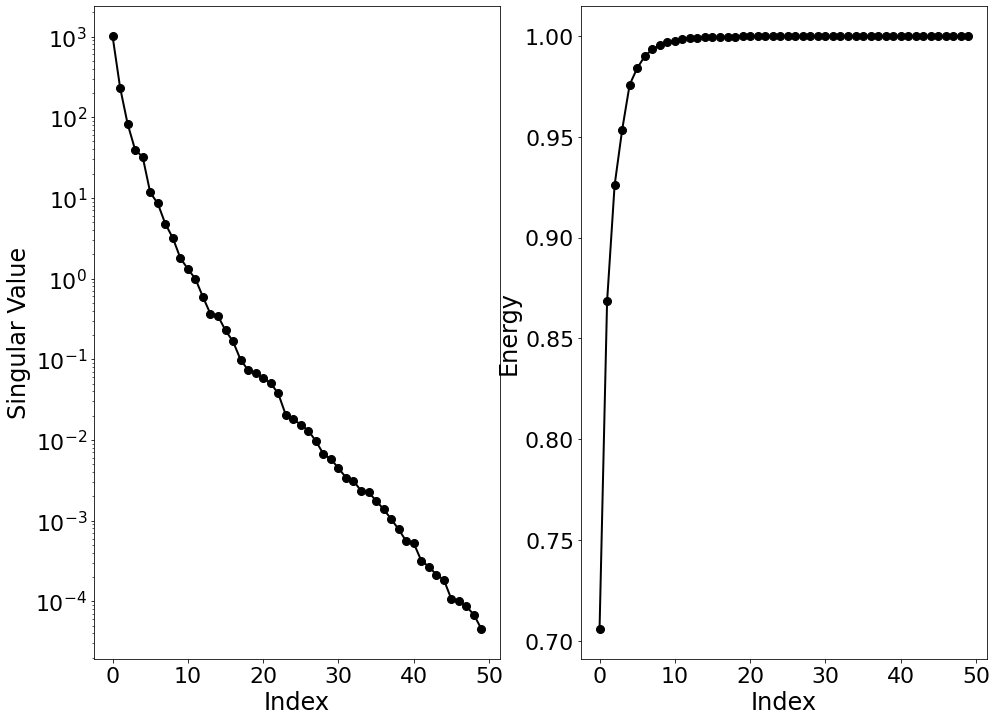

In [8]:
U, S, VT = np.linalg.svd(yMat.T, full_matrices=1)
V        = VT.T

fig1 = plt.figure(figsize=(16, 12))

ax1 = fig1.add_subplot(121)
ax1.semilogy(S,'-o',color='k')
ax1.set_xlabel('Index', fontsize=24)
ax1.set_ylabel('Singular Value', fontsize=24)
#ax1.set_xticks(fontsize=20)
#ax1.set_yticks(fontsize=20)

ax2 = fig1.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
ax2.set_xlabel('Index', fontsize=24)
ax2.set_ylabel('Energy', fontsize=24)
#ax2.set_xticks(fontsize=20)
#ax2.set_yticks(fontsize=20)

plt.show()

In [9]:
from PCAfold import PCA as PCAA

pca        = PCAA(yMat.T, scaling='pareto', n_components=NVarsRed)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NVarsRed].T
L          = pca.L
AT         = A.T

# yMat_pca   = ((yMat.T - C)/D).dot(AT)
# yMat_      = ((yMat_pca.dot(A))*D + C).T

# yMat_pca   = ((yMat.T)/D).dot(AT)
# yMat_      = ((yMat_pca.dot(A))*D).T

yMat_pca   = ((yMat.T).dot(AT))
yMat_      = ((yMat_pca.dot(A))).T

# yMat_pca   = pca.transform(yMat.T, nocenter=False)
# yMat_      = pca.reconstruct(yMat_pca, nocenter=False).T


## For Verification: 
print('Shape of yMat_pca = ', yMat_pca.shape)
print('Shape of A        = ', A.shape)
print('Error = ', np.max(abs(yMat - yMat_)))

Shape of yMat_pca =  (3600, 4)
Shape of A        =  (4, 50)
Error =  1.5367193431758999


In [10]:
# Y0_pca = ((Y0.T - C)/D).dot(AT)
# Y0_    = ((Y0_pca.dot(A))*D + C).T

# Y0_pca = ((Y0.T)/D).dot(AT)
# Y0_    = ((Y0_pca.dot(A))*D).T

Y0_pca = (Y0.T).dot(AT)
Y0_    = ((Y0_pca.dot(A))).T

print('Error = ', np.max(abs(Y0 - Y0_)))

y0_pca = np.zeros((NVarsRed*Nx))
for i in range(0,NVarsRed):
    y0_pca[0+i*Nx:Nx+i*Nx] = Y0_pca[:,i]

Error =  0.15320004595502734


In [11]:
#RHS function
def DiffReacAdvODE_Red(x, y, dx, xx, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec, AA, CC, DD):
    ns_Red = AA.shape[1]
    ns     = AA.shape[0]
    nx     = int(len(y)/NVarsRed)
    dydt   = np.zeros(y.shape[0])
    
#     KInelT_Red = np.matmul( APCA, np.matmul(KInelT, APCA.T) )
#     KDiss_Red  = np.matmul( APCA, np.matmul(np.diag(KDiss), APCA.T) )
#     KRec_Red   = np.matmul( APCA, np.matmul(np.diag(KRec), APCA.T) )
    
    Y = np.zeros((NVarsRed, Nx))
    for iS in range(NVarsRed):
        Y[iS,:] = y[0+iS*Nx:Nx+iS*Nx]
        
#     dYdt  = np.zeros((ns,nx))
#     dYdxx = np.zeros((ns,1))
#     for iX in range(-1,nx-1):
#         DiffM      = DiffFun(xx[iX])
#         AdvecM     = AdvecFun(xx[iX])
#         ReacM      = ReacFun(xx[iX])
        
#         Diff       = np.matmul(DiffM, (Y[:,iX+1] - 2.*Y[:,iX] + Y[:,iX-1]) / (dx*dx) )
#         Advec      = np.matmul(AdvecM, (Y[:,iX+1] - Y[:,iX-1]) / (dx) )
#         Reac       = np.matmul(ReacM, Y[:,iX])
#         dYdt[:,iX] = Diff + Advec + Reac

    dYdt_Diff = np.zeros((NVarsRed,Nx))
    Y_Adv     = np.zeros((NVarsRed,Nx))
    for iX in range(-1,nx-1):
        DiffM           = DiffFun(xx[iX], Ns)
        DiffM_Red       = AA @ (DiffM) @ AA.T
        dYdt_Diff[:,iX] = np.matmul(DiffM_Red, (Y[:,iX+1] - Y[:,iX-1]) / (2.*dx) )
        AdvecM          = AdvecFun(xx[iX], Ns)
        AdvecM_Red      = AA @ (AdvecM) @ AA.T
        Y_Adv[:,iX]     = np.matmul(AdvecM_Red, Y[:,iX])
        
    dYdt  = np.zeros((NVarsRed,Nx))
    for iX in range(-1,Nx-1):
        Diff       = (dYdt_Diff[:,iX+1] - dYdt_Diff[:,iX-1]) / (2.*dx)
        Advec      = (    Y_Adv[:,iX+1] -     Y_Adv[:,iX-1]) / (2.*dx)
            
#         #KInel, KDiss, KRec = ReacFun(xx[iX], ns)
#         Reac       = Diff*0.0
#         Reac[0:-1] = (- KDiss*Y[0:-1,iX] + KRec*Y[-1,iX]**2)*Y[-1,iX] #+ (np.matmul(KInelT, Y[0:-1,iX]))*Y[-1,iX]
#         Reac[-1]   = np.sum( (KDiss*Y[0:-1,iX] - KRec*Y[-1,iX]**2)*Y[-1,iX] )
#         Reac       = np.matmul(APCA, Reac)
        
        KInelT_Red = AA @ (KInelT) @ AA.T
        Reac       = np.matmul(KInelT_Red, Y[:,iX])
        
        dYdt[:,iX] = Reac + Diff + Advec #Diff + Advec + Reac
        
    
    dydt = dYdt.flatten()
        
    return dydt

In [12]:
#define ode solver
r = ode(DiffReacAdvODE_Red).set_integrator('vode', method='bdf', order=5, atol=1e-15)
r.set_initial_value(y0_pca, 0.0).set_f_params(dx, xx, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec, A, C, D)

#run integation
xMat_Red  = np.zeros((NVarsRed,Nx))
yMat_Red  = np.zeros((NVarsRed,Nx))
yTemp_Red = np.zeros((NVarsRed,Nx))
for i in range(0,NVarsRed):
    xMat_Red[i,:] =  x[0+i*Nx:Nx+i*Nx]
    yMat_Red[i,:] = y0_pca[0+i*Nx:Nx+i*Nx]

tVec = [0.0]  
while r.successful() and r.t < t1:
    print(r.t+dt)
    tVec.append(r.t+dt)
    y_next_Red = r.integrate(r.t+dt)
    for i in range(0,NVarsRed):
        yTemp_Red[i,:] = y_next_Red[0+i*Nx:Nx+i*Nx]
    yMat_Red = np.concatenate((yMat_Red,yTemp_Red), axis=1)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999


In [13]:
#yMat_ = ((yMat_Red.T.dot(A))*D + C).T

#yMat_ = ((yMat_Red.T.dot(A))*D).T

yMat_ = ((yMat_Red.T.dot(A))).T

print(np.max(yMat - yMat_))

1.5015825817924515


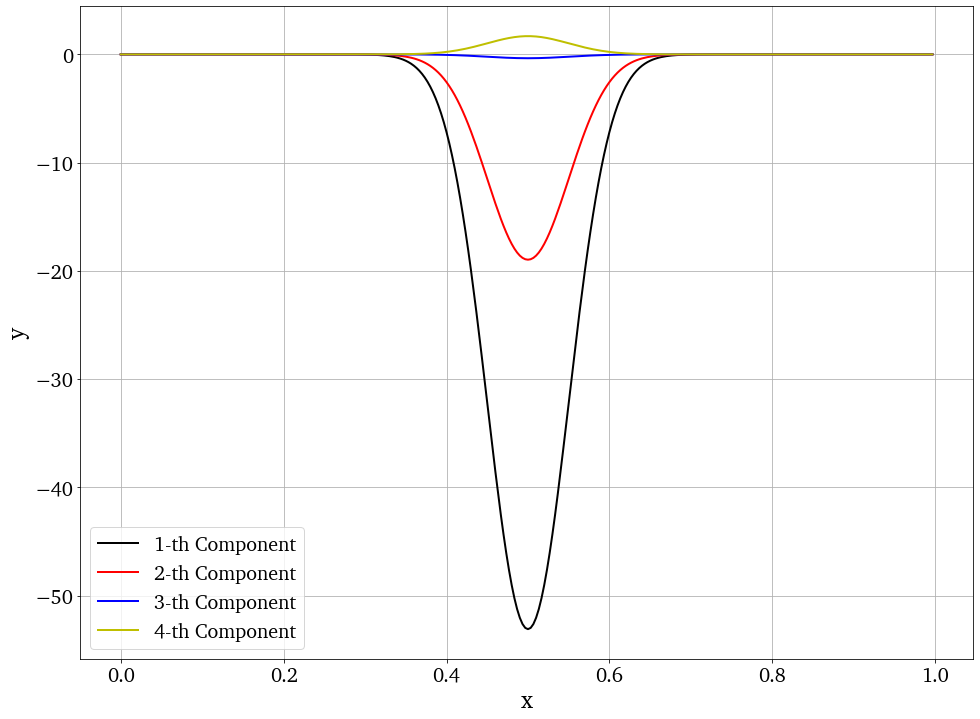

In [14]:
ColorVec = ['k','r','b','y','g','m','c']*10

# for i in range(0,ns):
#     plt.plot(x[0+i*nx:nx+i*nx],y0[0+i*nx:nx+i*nx], 'b-')  #initial condition
fig = plt.figure(figsize=(16, 12))

Nt    = int(yMat_Red.shape[1]/Nx)
it    = 0
for i in range(0,NVarsRed):
    plt.plot(x[0+i*Nx:Nx+i*Nx], yMat_Red[i,0+it*Nx:Nx+it*Nx], ColorVec[i]+'-', label=str(i+1)+'-th Component')  #solutions at time t=t1
    
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

NYDim  = NVarsRed
Header = "# t,x"
for iY in range(NYDim):
    Header = Header + ",y" + str(iY+1)
with open('/Users/sventuri/Desktop/PCA_Data.csv', 'w') as f:
    f.write(Header+'\n')
    iTot=0
    for it in range(Nt):
        for ix in range(Nx):
            Str = "{:.8e}".format(tVec[it])+','"{:.8e}".format(x[ix])
            for y in yMat_Red[:,iTot]:
                Str = Str + ',' + "{:.8e}".format(y) 
            f.write(Str+'\n')
            iTot+=1

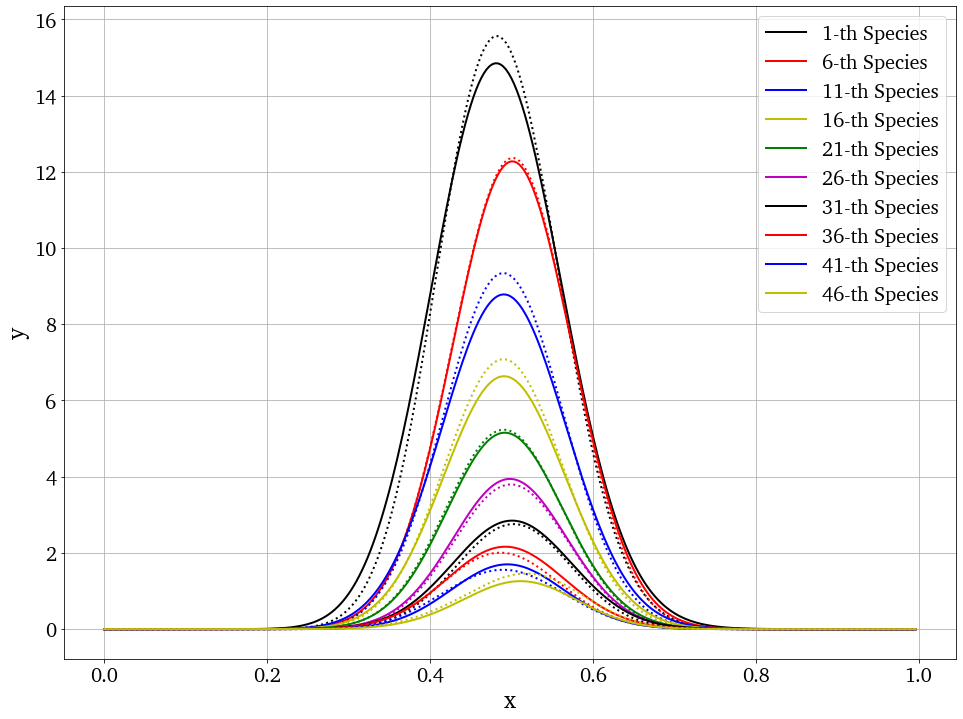

In [15]:
ColorVec = ['k','r','b','y','g','m']*4

# for i in range(0,ns):
#     plt.plot(x[0+i*nx:nx+i*nx],y0[0+i*nx:nx+i*nx], 'b-')  #initial condition
fig = plt.figure(figsize=(16, 12))

Nt    = int(yMat_.shape[1]/Nx)
it    = 4
iFig  = 0
for i in range(0,Ns,5):
    plt.plot(x[0+i*Nx:Nx+i*Nx], yMat[i,0+it*Nx:Nx+it*Nx],  ColorVec[iFig]+'-', label=str(i+1)+'-th Species')  #solutions at time t=t1
    plt.plot(x[0+i*Nx:Nx+i*Nx], yMat_[i,0+it*Nx:Nx+it*Nx], ColorVec[iFig]+':', linewidth=2)  #solutions at time t=t1
    iFig+=1
    
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()